# FC25 — Analyse Exploratoire & Scouting Insights

## Contexte
Ce notebook analyse la base **male_players.csv** (FC25) afin d’extraire des insights de scouting et de construire des indicateurs utiles : profils par poste, corrélations avec l’OVR, pépites, shortlists, estimation de valeur marché, et prédiction d’OVR via ML.

## Objectifs du projet

Ce projet vise à exploiter le dataset FC25 afin de proposer une analyse data-driven complète orientée **performance** et **scouting**. Les objectifs principaux sont les suivants :

- Explorer et comprendre la distribution de la note globale (**OVR**) et ses déterminants.
- Analyser l’influence des attributs techniques, cognitifs et physiques sur l’OVR, à l’échelle globale et par poste.
- **Enrichir les données de position** en intégrant les positions alternatives des joueurs afin d’élargir l’analyse des profils.
- Proposer des listes de recrutement (pépites / shortlists)
- Estimer un prix de marché (approche heuristique)
- Construire un **indice de compatibilité tactique** permettant d’évaluer l’adéquation des joueurs à différents styles de jeu (contre-attaque, possession, bloc bas).
- Réaliser une **analyse qualité / prix (Value for Money)** pour identifier des profils performants et économiquement intéressants.
- Tester un modèle ML simple pour prédire l’OVR

## Dataset
- Fichier : `male_players.csv`
- Cible principale : `OVR`
- Population : joueurs de champ (les gardiens sont séparés)

## Bibliothèques utilisées

- **pandas**  
  Bibliothèque principale pour la manipulation et l’analyse des données tabulaires (chargement du dataset, nettoyage, filtrage, agrégations).

- **numpy**  
  Utilisée pour les calculs numériques, la gestion des valeurs manquantes et certaines opérations mathématiques vectorisées.

- **matplotlib**  
  Bibliothèque de visualisation de base permettant de créer des graphiques personnalisés (histogrammes, scatter plots, bar charts).

- **seaborn**  
  Extension de matplotlib facilitant la création de visualisations statistiques plus lisibles et esthétiques (distributions, boxplots, heatmaps).

- **scikit-learn (sklearn)**  
  Bibliothèque de machine learning utilisée pour :
  - la séparation des données (train/test),
  - l’entraînement du modèle **Random Forest Regressor**,
  - l’évaluation des performances (R², MAE).

In [ ]:
# Importation des bibliothèques

# Manipulation et analyse des données
import pandas as pd
import numpy as np

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

## Étape 1 — Chargement et préparation des données

**But :** charger le dataset, nettoyer les noms de colonnes, supprimer les colonnes inutiles et séparer :
- `df_gk` : gardiens
- `df_field` : joueurs de champ

**Sorties attendues :**
- dimensions du dataset total
- dimensions GK vs Field

In [ ]:


df = pd.read_csv("male_players.csv")

# 1) Supprimer colonnes d’index inutiles
df = df.drop(columns=[c for c in df.columns if c.startswith("Unnamed")], errors="ignore")

# 2) Nettoyer noms de colonnes
df.columns = (
    df.columns
      .str.strip()
      .str.replace(" ", "_")
      .str.replace("/", "_")
      .str.replace("-", "_")
)

# 3) Séparer gardiens vs joueurs de champ 
gk_cols = ["GK_Diving", "GK_Handling", "GK_Kicking", "GK_Positioning", "GK_Reflexes"]
is_gk = df[gk_cols].notna().any(axis=1)  # True si au moins une stat GK existe
  
df_gk = df[is_gk].copy()
df_field = df[~is_gk].copy()

print("Total:", df.shape)
print("Gardiens:", df_gk.shape)
print("Joueurs de champ:", df_field.shape)


Total: (16161, 56)
Gardiens: (1816, 56)
Joueurs de champ: (14345, 56)


## Étape 2 — Analyse exploratoire (EDA)

**But :** explorer la distribution de l’OVR et observer des tendances simples (Top joueurs, variations par poste, relation âge-OVR).


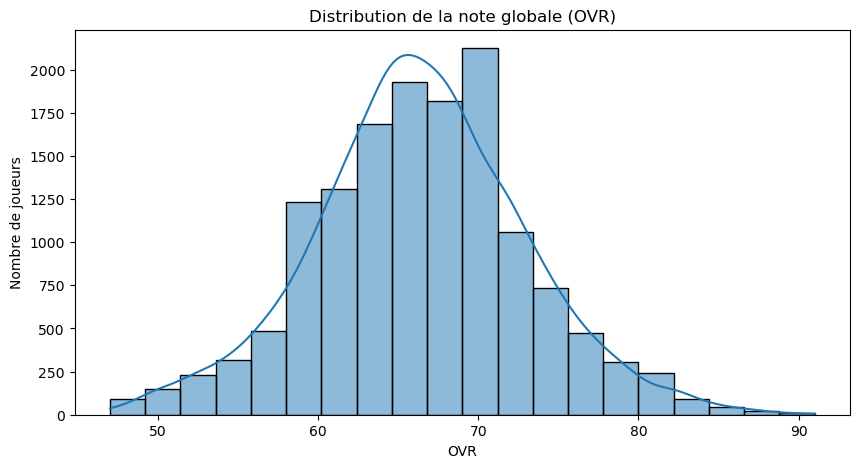

In [3]:

plt.figure(figsize=(10,5))
sns.histplot(df_field["OVR"], bins=20, kde=True)
plt.title("Distribution de la note globale (OVR)")
plt.xlabel("OVR")
plt.ylabel("Nombre de joueurs")
plt.show()


### 2.1 Distribution de la note OVR


**Interprétation :**

La distribution de la note globale (OVR) suit une forme proche d’une loi normale, centrée autour de valeurs comprises entre **65 et 70**.  
Cela indique que la majorité des joueurs présents dans le dataset ont un niveau **moyen à bon**, correspondant à des joueurs professionnels standards.

On observe :
- Une **forte concentration** de joueurs dans l’intervalle **60–75**, qui représente le cœur du marché.
- Une **queue droite plus étirée**, montrant que les joueurs très bien notés (OVR > 80) sont **rares**, ce qui reflète leur caractère élite.
- Peu de joueurs avec un OVR très faible (< 55), suggérant que le dataset exclut majoritairement les profils amateurs.

Cette distribution est cohérente avec un contexte de **scouting** :  
les joueurs à OVR élevé constituent des profils d’exception, tandis que la masse principale correspond à des opportunités de recrutement réalistes pour la majorité des clubs.



/tmp/ipykernel_28304/344638262.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


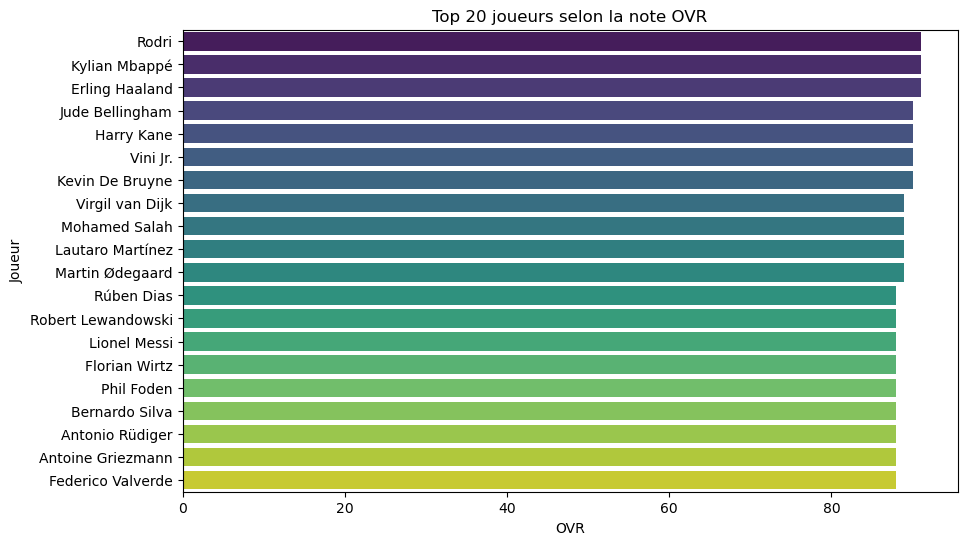

In [4]:
top20 = df_field.sort_values("OVR", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top20,
    y="Name",
    x="OVR",
    palette="viridis"
)
plt.title("Top 20 joueurs selon la note OVR")
plt.xlabel("OVR")
plt.ylabel("Joueur")
plt.show()


### 2.2 Top 20 joueurs selon l’OVR

**Interprétation :**

Ce classement met en évidence l’élite mondiale des joueurs selon la note globale (OVR).  
On observe que les **20 meilleurs joueurs** possèdent tous une note très élevée, généralement **supérieure ou égale à 88**, ce qui confirme leur statut de références internationales.

Plusieurs éléments ressortent :
- Une **forte diversité de postes** (milieux, attaquants, défenseurs), indiquant que l’OVR intègre une évaluation globale adaptée au rôle du joueur.
- Une **présence dominante de joueurs offensifs et créatifs**, souvent décisifs sur le plan statistique et tactique.
- Des écarts relativement faibles entre les notes, ce qui souligne que, à ce niveau d’élite, les différences de performance sont **marginales mais critiques**.

Du point de vue scouting, ces joueurs représentent des profils :
- à **coût de transfert très élevé**,
- à **faible disponibilité sur le marché**,
- servant davantage de **benchmark** pour comparer des profils émergents ou sous-cotés plutôt que de véritables cibles de recrutement.


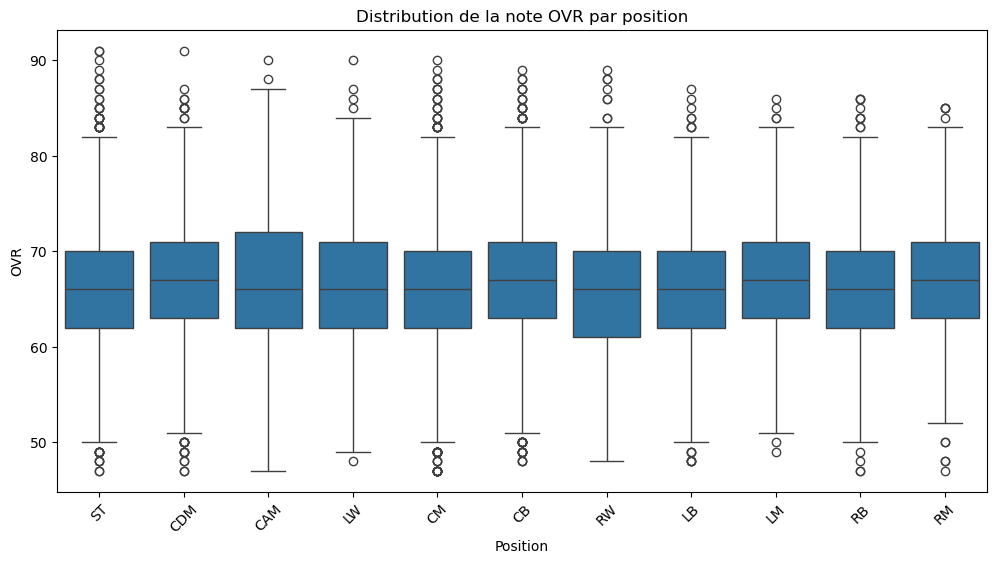

In [5]:
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_field,
    x="Position",
    y="OVR"
)
plt.title("Distribution de la note OVR par position")
plt.xlabel("Position")
plt.ylabel("OVR")
plt.xticks(rotation=45)
plt.show()



### 2.3 Distribution de l’OVR par poste

**Ce qu’on cherche :**
- postes qui ont des médianes plus élevées
- postes avec forte dispersion (variabilité)
- outliers (joueurs très au-dessus du niveau moyen)

**Interprétation :**

La distribution de la note OVR par position montre que les médianes sont relativement proches d’un poste à l’autre, généralement comprises entre **65 et 68**, ce qui indique un niveau moyen globalement homogène entre les rôles.

Cependant, plusieurs différences notables apparaissent :
- Les postes **offensifs et créatifs** (CAM, LW, RW, LM, RM) présentent une **dispersion plus élevée**, traduisant une forte hétérogénéité de profils, allant de joueurs moyens à des joueurs d’élite.
- Les **défenseurs centraux (CB)** affichent une médiane légèrement plus élevée et une dispersion plus contenue, suggérant des profils plus standardisés et stables.
- Les postes de **latéraux (LB, RB)** montrent une variabilité intermédiaire, reflétant des rôles hybrides combinant qualités défensives et offensives.

La présence d’**outliers élevés** pour presque tous les postes confirme que des joueurs d’exception existent indépendamment du rôle, mais qu’ils restent minoritaires.

D’un point de vue scouting, cette analyse suggère que :
- les postes offensifs offrent davantage d’opportunités pour identifier des profils différenciants,
- tandis que les postes défensifs reposent davantage sur la régularité et la fiabilité que sur des notes extrêmes.



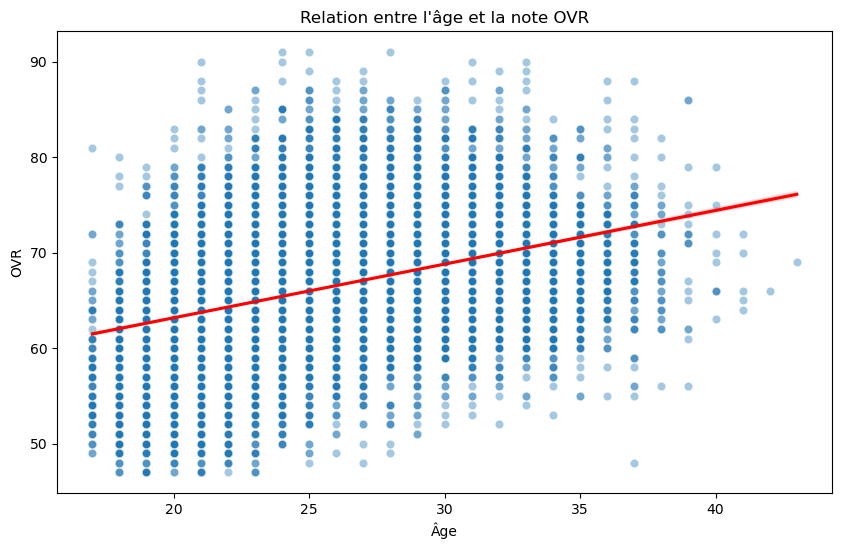

In [6]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_field,
    x="Age",
    y="OVR",
    alpha=0.4
)

sns.regplot(
    data=df_field,
    x="Age",
    y="OVR",
    scatter=False,
    color="red"
)

plt.title("Relation entre l'âge et la note OVR")
plt.xlabel("Âge")
plt.ylabel("OVR")
plt.show()


### 2.4 Relation entre l’âge et l’OVR

**Ce qu’on cherche :**
- tendance globale (croissance puis plateau ou baisse)
- présence d’un pic d’âge (prime)
- dispersion (jeunes très forts / vieux encore performants)

**Interprétation :**

La relation entre l’âge et la note OVR met en évidence une **tendance globalement positive**, comme l’indique la droite de régression.  
En moyenne, la note OVR augmente avec l’âge, ce qui reflète l’impact de l’**expérience et de la maturité** sur la performance globale des joueurs.

Cependant, cette relation n’est pas strictement linéaire :
- Chez les **jeunes joueurs (18–22 ans)**, on observe une forte dispersion, avec de nombreux profils encore en développement mais déjà quelques joueurs très performants.
- La **zone de performance optimale** semble se situer approximativement entre **24 et 30 ans**, où l’on retrouve la plus forte concentration de joueurs avec des OVR élevés.
- Au-delà de **30–32 ans**, la dispersion reste importante, suggérant que certains joueurs maintiennent un très haut niveau, tandis que d’autres voient leur performance décliner.

Du point de vue du scouting, cette analyse souligne l’importance de :
- distinguer le **potentiel futur** chez les jeunes joueurs de la performance actuelle,
- identifier les profils capables de conserver un haut niveau malgré l’âge,
- adapter les stratégies de recrutement selon les objectifs du club (développement à long terme vs performance immédiate).


## Étape 3 — Corrélation entre OVR et attributs

**But :** mesurer quels attributs numériques sont le plus associés à l’OVR (corrélation linéaire), puis analyser par grande famille de postes (attaque / milieu / défense).


In [ ]:
# Sélection des colonnes numériques pertinentes (hors GK)
attributes = [
       'Acceleration', 'Sprint_Speed', 'Positioning', 'Finishing',
       'Shot_Power', 'Long_Shots', 'Volleys', 'Penalties', 'Vision',
       'Crossing', 'Free_Kick_Accuracy', 'Short_Passing', 'Long_Passing',
       'Curve', 'Dribbling', 'Agility', 'Balance', 'Reactions', 'Ball_Control',
       'Composure', 'Interceptions', 'Heading_Accuracy', 'Def_Awareness',
       'Standing_Tackle', 'Sliding_Tackle', 'Jumping', 'Stamina', 'Strength',
       'Aggression'
]

# Garder uniquement les colonnes existantes
attributes = [col for col in attributes if col in df_field.columns]

print(df_field.columns)
corr_df = df_field[attributes + ["OVR"]].corr()


Index(['Rank', 'Name', 'OVR', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY',
       'Acceleration', 'Sprint_Speed', 'Positioning', 'Finishing',
       'Shot_Power', 'Long_Shots', 'Volleys', 'Penalties', 'Vision',
       'Crossing', 'Free_Kick_Accuracy', 'Short_Passing', 'Long_Passing',
       'Curve', 'Dribbling', 'Agility', 'Balance', 'Reactions', 'Ball_Control',
       'Composure', 'Interceptions', 'Heading_Accuracy', 'Def_Awareness',
       'Standing_Tackle', 'Sliding_Tackle', 'Jumping', 'Stamina', 'Strength',
       'Aggression', 'Position', 'Weak_foot', 'Skill_moves', 'Preferred_foot',
       'Height', 'Weight', 'Alternative_positions', 'Age', 'Nation', 'League',
       'Team', 'play_style', 'url', 'GK_Diving', 'GK_Handling', 'GK_Kicking',
       'GK_Positioning', 'GK_Reflexes'],
      dtype='object')


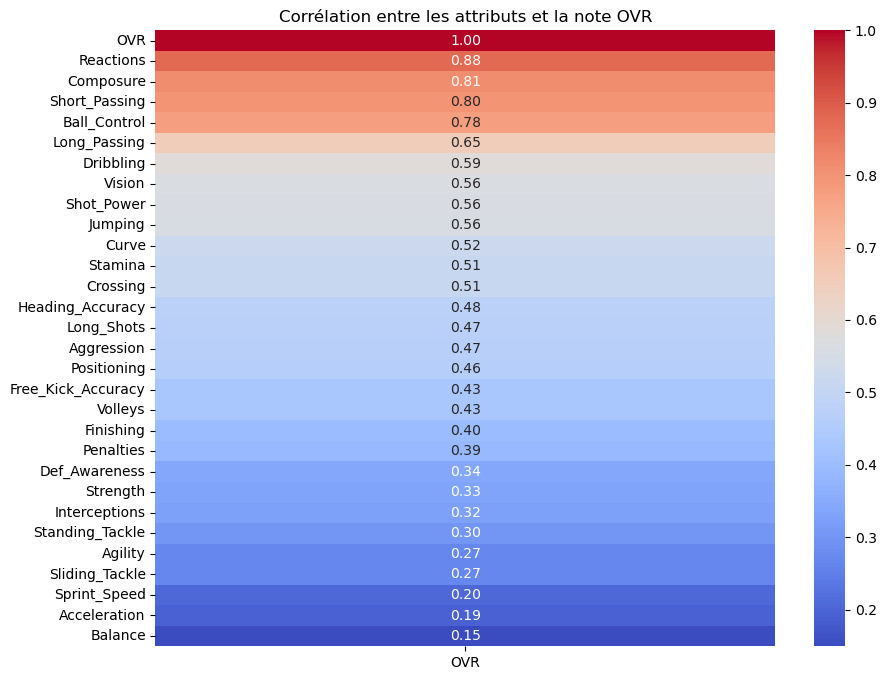

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_df[["OVR"]].sort_values(by="OVR", ascending=False),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Corrélation entre les attributs et la note OVR")
plt.show()


### 3.1 Corrélation attributs ↔ OVR (global)

**Interprétation :**

La matrice de corrélation met en évidence que la note globale (OVR) est principalement expliquée par des **attributs techniques et cognitifs**, plutôt que par des caractéristiques purement physiques.

Les corrélations les plus élevées sont observées pour :
- **Reactions (0.88)** et **Composure (0.81)**, indiquant que la réactivité et le sang-froid sont des facteurs déterminants du niveau global.
- Les qualités techniques liées au jeu collectif, telles que **Short Passing (0.80)**, **Ball Control (0.78)** et **Long Passing (0.65)**.
- Les attributs de créativité et d’intelligence de jeu comme **Vision (0.56)** et **Dribbling (0.59)**.

À l’inverse, les attributs principalement **physiques** (Sprint Speed, Acceleration, Balance) présentent des corrélations nettement plus faibles, ce qui suggère qu’ils jouent un rôle secondaire dans le calcul de l’OVR.

Les attributs défensifs (Def Awareness, Interceptions, Tackles) montrent des corrélations modérées, ce qui est cohérent avec le fait que l’OVR soit une évaluation transversale, indépendante du poste spécifique.

D’un point de vue analytique et scouting, cette analyse confirme que :
- l’OVR valorise davantage la **qualité décisionnelle et technique** que la vitesse brute,
- les joueurs “intelligents” et techniquement complets sont favorisés dans l’évaluation globale,
- les critères physiques doivent être interprétés en complément, notamment selon le poste et le style de jeu.


/tmp/ipykernel_28304/2072118553.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


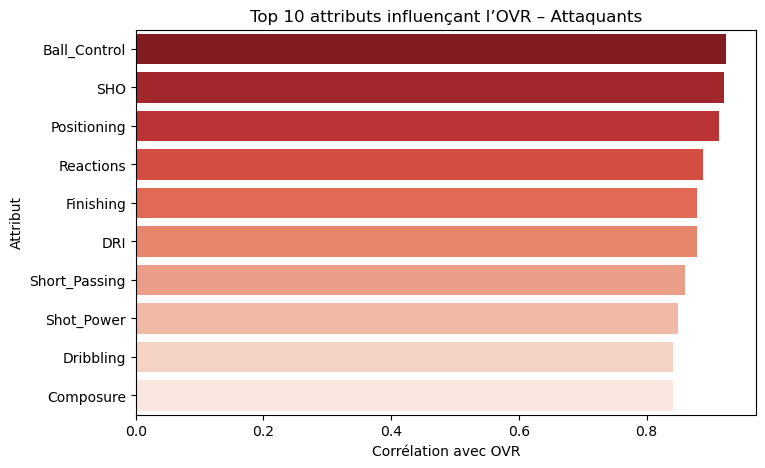

In [9]:
attack_positions = ["ST", "CF", "LW", "RW"]
df_attack = df_field[df_field["Position"].isin(attack_positions)]

# Colonnes numériques (hors OVR)
num_cols = df_attack.select_dtypes(include="number").columns.drop("OVR")

# Corrélation avec OVR
attack_corr = (
    df_attack[num_cols]
    .corrwith(df_attack["OVR"])
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8,5))
sns.barplot(
    x=attack_corr.values,
    y=attack_corr.index,
    palette="Reds_r"
)
plt.title("Top 10 attributs influençant l’OVR – Attaquants")
plt.xlabel("Corrélation avec OVR")
plt.ylabel("Attribut")
plt.show()


### 3.2 Attributs clés — Attaquants 

**Interprétation :**
Chez les attaquants, la note OVR est principalement influencée par le **contrôle du ballon**, la **qualité de frappe**, le **placement offensif** et la **réactivité**, soulignant l’importance de l’efficacité dans les situations décisives.


/tmp/ipykernel_28304/1669229999.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


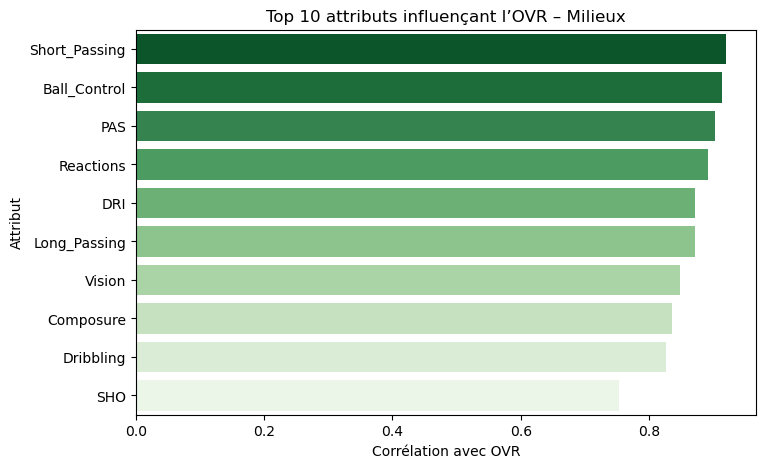

In [10]:
mid_positions = ["CM", "CAM", "CDM"]
df_mid = df_field[df_field["Position"].isin(mid_positions)]

num_cols = df_mid.select_dtypes(include="number").columns.drop("OVR")

mid_corr = (
    df_mid[num_cols]
    .corrwith(df_mid["OVR"])
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8,5))
sns.barplot(
    x=mid_corr.values,
    y=mid_corr.index,
    palette="Greens_r"
)
plt.title("Top 10 attributs influençant l’OVR – Milieux")
plt.xlabel("Corrélation avec OVR")
plt.ylabel("Attribut")
plt.show()


### 3.2 Attributs clés —  Milieux 

**Interprétation :**
Pour les milieux de terrain, l’OVR est fortement corrélée aux **qualités de passe**, au **contrôle du jeu** et à la **vision**, reflétant leur rôle central dans l’organisation et la fluidité du jeu.


/tmp/ipykernel_28304/3691153308.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


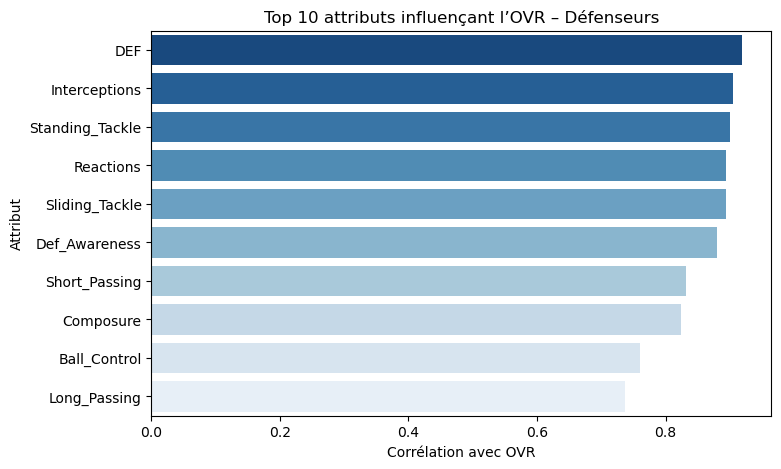

In [11]:
def_positions = ["CB", "LB", "RB"]
df_def = df_field[df_field["Position"].isin(def_positions)]

num_cols = df_def.select_dtypes(include="number").columns.drop("OVR")

def_corr = (
    df_def[num_cols]
    .corrwith(df_def["OVR"])
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8,5))
sns.barplot(
    x=def_corr.values,
    y=def_corr.index,
    palette="Blues_r"
)
plt.title("Top 10 attributs influençant l’OVR – Défenseurs")
plt.xlabel("Corrélation avec OVR")
plt.ylabel("Attribut")
plt.show()


### 3.2 Attributs clés —  Défenseurs

**Interprétation :**
Chez les défenseurs, les attributs défensifs tels que les **interceptions**, le **tacle**, la **lecture du jeu** et la **réactivité** dominent, confirmant que la solidité et l’anticipation sont clés dans l’évaluation globale.


## Étape 4 — Enrichissement des positions alternatives

**But :**

-Approche relative basée sur les Top 8 attributs

-Score par rôle (≥ 3 attributs clés)

-Filtrage par famille de postes

-éviter de dupliquer la position principale dans les positions alternatives

**Pourquoi :**
Cela permet d’élargir la recherche de profils (ex : un joueur “CM” jouable “CAM/CDM”).

In [12]:


# --- 1) Trouver automatiquement la colonne Alternative Position ---
def find_alt_col(columns):
    for c in columns:
        low = c.lower()
        if "alternative" in low and "position" in low:
            return c
    raise ValueError("Colonne Alternative Position introuvable. Vérifie le nom exact après nettoyage.")

ALT_COL = find_alt_col(df_field.columns)

# --- 2) Split positions (ex: 'LW/RW, CAM' -> {'LW','RW','CAM'}) ---
def split_positions(s):
    if pd.isna(s) or str(s).strip() == "":
        return set()
    s = str(s).upper().replace(";", ",").replace("/", ",")
    return {p.strip() for p in s.split(",") if p.strip()}

# --- 3) Mapping attributs -> rôles (logique métier) ---
ROLE_ATTRS = {
    "ATTACK": {
        "attrs": ["Finishing","Positioning","Shot_Power","Reactions","Ball_Control","Dribbling","Composure","Acceleration","Sprint_Speed"],
        "positions": ["ST","CF"]
    },
    "WINGER": {
        "attrs": ["Sprint_Speed","Acceleration","Dribbling","Agility","Ball_Control","Crossing","Balance","Reactions"],
        "positions": ["LW","RW"]
    },
    "AM": {
        "attrs": ["Vision","Short_Passing","Long_Passing","Ball_Control","Reactions","Composure","Curve","Long_Shots","Agility"],
        "positions": ["CAM"]
    },
    "CM": {
        "attrs": ["Short_Passing","Long_Passing","Vision","Stamina","Ball_Control","Reactions","Composure","Balance"],
        "positions": ["CM"]
    },
    "CDM": {
        "attrs": ["Def_Awareness","Interceptions","Standing_Tackle","Strength","Aggression","Stamina","Short_Passing","Reactions"],
        "positions": ["CDM"]
    },
    "DEFENDER": {
        "attrs": ["Def_Awareness","Standing_Tackle","Sliding_Tackle","Interceptions","Strength","Jumping","Heading_Accuracy","Aggression","Reactions"],
        "positions": ["CB"]
    },
    "FULLBACK": {
        "attrs": ["Sprint_Speed","Acceleration","Stamina","Crossing","Standing_Tackle","Def_Awareness","Ball_Control","Agility"],
        "positions": ["LB","RB"]
    }
}



In [13]:
# Attributs candidats = union de tous les attributs utilisés dans ROLE_ATTRS, présents dans le dataset
candidate_attrs = sorted({a for r in ROLE_ATTRS.values() for a in r["attrs"] if a in df_field.columns})

TOP_K = 8
MIN_SCORE = 3

FAMILY = {
    "ST":"ATT", "CF":"ATT", "LW":"WING", "RW":"WING",
    "CAM":"MID", "CM":"MID", "CDM":"MID",
    "CB":"DEF", "LB":"DEF", "RB":"DEF",
    "GK":"GK"
}

ALLOWED_BY_FAMILY = {
    "ATT": {"ST","CF","LW","RW","CAM"},
    "WING": {"LW","RW","ST","CF","CAM","LM","RM"},
    "MID": {"CAM","CM","CDM","LM","RM"},
    "DEF": {"CB","LB","RB","CDM"},
    "GK": {"GK"}
}


def infer_alt_positions_topk(row):
    main_pos = str(row["Position"]).strip().upper()
    existing_alt = split_positions(row.get(ALT_COL, np.nan))

    # --- TOP 8 ATTRIBUTS ---
    vals = row[candidate_attrs].astype(float)
    if vals.notna().sum() < 6:
        return np.nan

    top_attrs = vals.sort_values(ascending=False).head(TOP_K).index.tolist()
    top_set = set(top_attrs)

    inferred_positions = set()

    # --- SCORE PAR RÔLE ---
    for role_name, role_def in ROLE_ATTRS.items():
        role_attrs_present = [a for a in role_def["attrs"] if a in candidate_attrs]
        score = sum(1 for a in role_attrs_present if a in top_set)

        if score >= MIN_SCORE:
            inferred_positions.update(role_def["positions"])

    family = FAMILY.get(main_pos)

    if family in ALLOWED_BY_FAMILY:
        inferred_positions = {
            p for p in inferred_positions
            if p in ALLOWED_BY_FAMILY[family]
        }


    inferred_positions.discard(main_pos)        # enlever position principale
    inferred_positions = inferred_positions - existing_alt  # enlever doublons

    if not inferred_positions:
        return np.nan

    return ", ".join(sorted(inferred_positions))



In [14]:
df_enriched = df_field.copy()

mask_missing = df_enriched[ALT_COL].isna() | (df_enriched[ALT_COL].astype(str).str.strip() == "")

before = mask_missing.sum()

df_enriched.loc[mask_missing, ALT_COL] = (
    df_enriched.loc[mask_missing].apply(infer_alt_positions_topk, axis=1)
)

after = (df_enriched[ALT_COL].isna() | (df_enriched[ALT_COL].astype(str).str.strip() == "")).sum()

print("Missing avant:", before)
print("Missing après :", after)

# Vérifier qu'on n'a jamais ajouté la position principale
check = df_enriched.dropna(subset=[ALT_COL]).copy()
bad = check[check.apply(lambda r: r["Position"].strip().upper() in split_positions(r[ALT_COL]), axis=1)]
print("Position principale présente dans Alternative Position:", bad.shape[0])

# Exemple de 10 joueurs remplis
df_enriched.loc[mask_missing, ["Name","Position",ALT_COL]].dropna().head(10)



Missing avant: 5431
Missing après : 129
Position principale présente dans Alternative Position: 0


,Name,Position,Alternative_positions
2,Erling Haaland,ST,CF
6,Harry Kane,ST,"CAM, CF"
11,Lautaro Martínez,ST,"CAM, CF, LW, RW"
12,Virgil van Dijk,CB,"CDM, LB, RB"
17,Antoine Griezmann,ST,"CAM, CF, LW, RW"
18,Rúben Dias,CB,CDM
19,Robert Lewandowski,ST,CF
24,Antonio Rüdiger,CB,"CDM, LB, RB"
27,William Saliba,CB,"CDM, LB, RB"
28,Victor Osimhen,ST,CF


## Étape 5 — Insights scouting

### 5.1 Pépite (U21) : élites vs sous-cotés
**Méthode :**
- U21 = `Age <= 21`
- “Élite” = top 5% en OVR chez les U21
- “Sous-coté” = score de force (Top8_Strength) élevé mais OVR < médiane U21

**Résultats :**
- Elite (extraits) : …
- Sous-cotés (extraits) : …



In [15]:
# Jeunes joueurs
young = df_enriched[df_enriched["Age"] <= 21].copy()

# Seuil élite = top 5% OVR chez les jeunes
elite_threshold = young["OVR"].quantile(0.95)
young_elite = young[young["OVR"] >= elite_threshold]

# Score de forces = moyenne des Top 8 attributs (déjà définis)
def topk_strength(row, k=8):
    vals = row[candidate_attrs].astype(float)
    return vals.sort_values(ascending=False).head(k).mean()

young["Top8_Strength"] = young.apply(topk_strength, axis=1)

# Sous-cotés : Top8_Strength élevé mais OVR sous la médiane des jeunes
strength_thr = young["Top8_Strength"].quantile(0.75)
ovr_med = young["OVR"].median()
young_undervalued = young[(young["Top8_Strength"] >= strength_thr) & (young["OVR"] < ovr_med)]

young_elite[["Name","Age","OVR","Position","Alternative_positions"]].head(10), \
young_undervalued[["Name","Age","OVR","Position","Alternative_positions","Top8_Strength"]].head(10)


(                  Name  Age  OVR Position Alternative_positions
 3      Jude Bellingham   21   90      CAM                    CM
 25       Florian Wirtz   21   88      CAM                    LM
 29       Jamal Musiala   21   87      CAM                LM, CM
 57               Pedri   21   86       CM                    LW
 135  Eduardo Camavinga   21   83       CM               CDM, LB
 167               Gavi   20   83       CM                    LW
 180        Xavi Simons   21   83      CAM                    LW
 253            Savinho   20   82       LW                    LM
 274     Destiny Udogie   21   82       LB           CB, CDM, RB
 285              Balde   20   81       LB                RB, LM,
                       Name  Age  OVR Position Alternative_positions  \
 13229  Juan David Carabalí   21   60       ST            CF, LW, RW   
 13422         Richard Koné   21   60       ST            CF, LW, RW   
 13518        Josh Mulligan   21   60       CM                RM, RB

5.2 Où recruter ? Comparaison Ligues & Nations


In [16]:
league_stats = (
    df_enriched.groupby("League")
    .agg(
        players=("Name","count"),
        avg_ovr=("OVR","mean"),
        avg_speed=("Sprint_Speed","mean"),
        avg_finishing=("Finishing","mean")
    )
    .query("players >= 200")
    .sort_values("avg_ovr", ascending=False)
    .head(10)
)

league_stats


,players,avg_ovr,avg_speed,avg_finishing
League,,,,
Premier League,528,74.532197,71.435606,57.793561
LALIGA EA SPORTS,475,73.903158,70.736842,59.111579
Serie A Enilive,476,73.571429,70.119748,57.670168
Bundesliga,424,73.091981,70.641509,56.952830
Ligue 1 McDonald's,410,72.119512,70.404878,55.456098
Liga Portugal,349,69.842407,69.779370,53.358166
Trendyol Süper Lig,337,68.596439,69.560831,53.700297
LALIGA HYPERMOTION,443,67.735892,67.525959,53.943567
Libertadores,505,67.550495,68.603960,53.031683


In [17]:
nation_stats = (
    df_enriched.groupby("Nation")
    .agg(players=("Name","count"), avg_ovr=("OVR","mean"))
    .query("players >= 100")
    .sort_values("avg_ovr", ascending=False)
    .head(10)
)

nation_stats


,players,avg_ovr
Nation,,
Brazil,320,71.231250
Portugal,303,70.541254
Spain,809,70.077874
Morocco,113,69.743363
Croatia,134,69.477612
Italy,438,69.408676
Côte d'Ivoire,102,69.039216
France,655,68.983206
Colombia,209,68.899522


Certaines ligues et nations concentrent davantage de joueurs rapides ou finisseurs, ce qui permet de cibler les zones géographiques les plus adaptées selon les besoins de l’équipe.

5.3 — Estimation du prix de marché des joueurs

5.3.1 Logique

La valeur marchande d’un joueur dépend de plusieurs facteurs combinant performance sportive, potentiel, rareté du poste et polyvalence tactique.
En l’absence de données réelles de prix, nous construisons un score de valeur marché composite, ensuite transformé en une estimation monétaire cohérente.

5.3.2 Définition des composantes du prix
1 Performance (60%)

OVR (facteur principal)

Top8_Strength (qualité intrinsèque)

2️ Âge (20%)

Bonus jeunes (≤ 23)

Neutre (24–28)

Décote progressive (> 29)

3️ Poste / rareté (12%)

ST / LW / RW → forte demande

CM / CAM / CB → demande moyenne

GK → marché plus stable

4️ Polyvalence (8%)

Nombre de positions jouables (principale + alternatives)

In [18]:
def topk_strength(row, k=8):
    vals = row[candidate_attrs].astype(float)
    if vals.notna().sum() < k:
        return np.nan
    return vals.sort_values(ascending=False).head(k).mean()

df_enriched["Top8_Strength"] = df_enriched.apply(topk_strength, axis=1)

from sklearn.preprocessing import MinMaxScaler

df_price = df_enriched.copy()

scaler = MinMaxScaler()

df_price[["OVR_norm", "Strength_norm"]] = scaler.fit_transform(
    df_price[["OVR", "Top8_Strength"]]
)

df_price["Performance_Score"] = (
    0.7 * df_price["OVR_norm"] +
    0.3 * df_price["Strength_norm"]
)



In [19]:
# Age factor

def age_factor(age):
    if age <= 23:
        return 1.2
    elif age <= 28:
        return 1.0
    elif age <= 32:
        return 0.85
    else:
        return 0.7

df_price["Age_Factor"] = df_price["Age"].apply(age_factor)


In [20]:
# Position factor

POSITION_WEIGHT = {
    "ST": 1.25, "LW": 1.25, "RW": 1.25,
    "CAM": 1.15, "CM": 1.15, "CB": 1.15,
    "CDM": 1.10,
    "LB": 1.05, "RB": 1.05,
    "GK": 1.00
}

df_price["Position_Factor"] = df_price["Position"].map(POSITION_WEIGHT).fillna(1.0)


In [21]:
# Polyvalence factor

def count_positions(row):
    main = 1
    alt = split_positions(row[ALT_COL])
    return main + len(alt)

df_price["Num_Positions"] = df_price.apply(count_positions, axis=1)
df_price["Polyvalence_Factor"] = 1 + (df_price["Num_Positions"] - 1) * 0.05


5.3.4 Score marché final + transformation en prix (€)

In [22]:
df_price["Market_Value_Score"] = (
    0.60 * df_price["Performance_Score"] +
    0.20 * (df_price["Age_Factor"] / df_price["Age_Factor"].max()) +
    0.12 * (df_price["Position_Factor"] / df_price["Position_Factor"].max()) +
    0.08 * (df_price["Polyvalence_Factor"] / df_price["Polyvalence_Factor"].max())
)

# Mise à l’échelle en millions d’euros
df_price["Estimated_Price_M€"] = (
    scaler.fit_transform(df_price[["Market_Value_Score"]]) * 120
).round(2)



5.3.5 Visualisations

/tmp/ipykernel_28304/3411642113.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


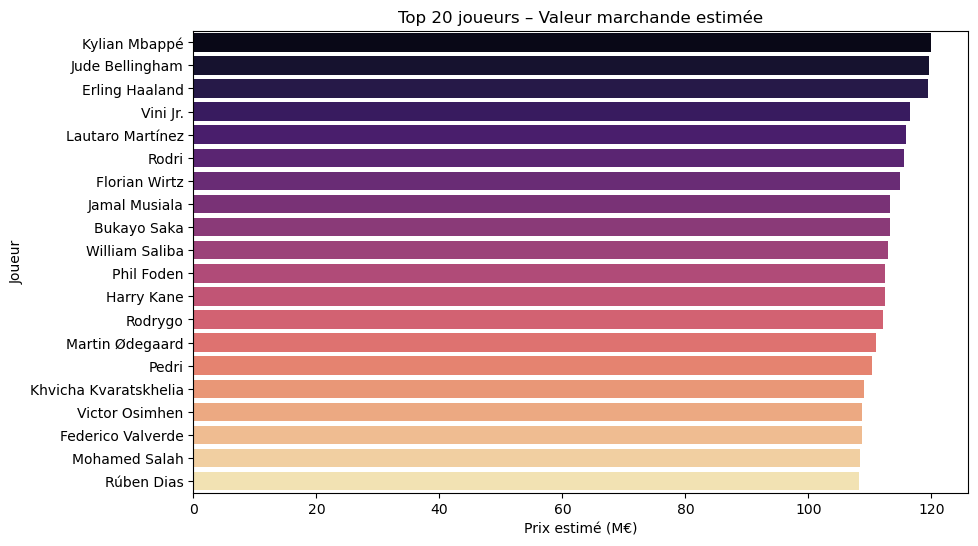

In [23]:
top20_price = df_price.sort_values("Estimated_Price_M€", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top20_price,
    y="Name",
    x="Estimated_Price_M€",
    palette="magma"
)
plt.title("Top 20 joueurs – Valeur marchande estimée")
plt.xlabel("Prix estimé (M€)")
plt.ylabel("Joueur")
plt.show()


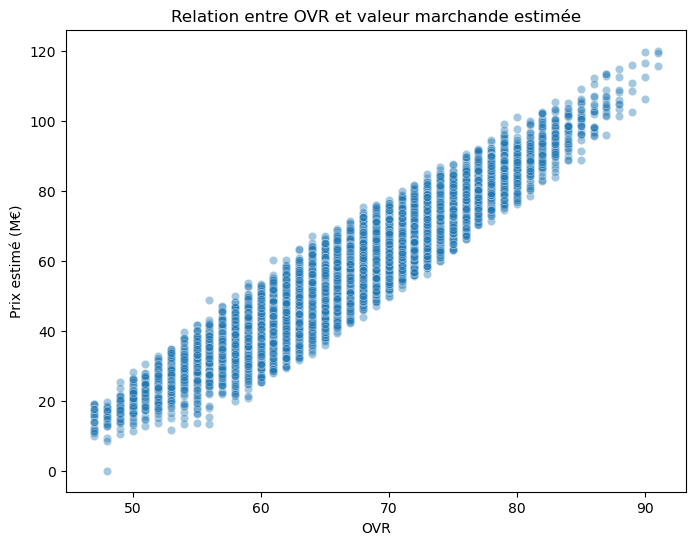

In [24]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_price,
    x="OVR",
    y="Estimated_Price_M€",
    alpha=0.4
)
plt.title("Relation entre OVR et valeur marchande estimée")
plt.xlabel("OVR")
plt.ylabel("Prix estimé (M€)")
plt.show()


Les joueurs jeunes avec OVR élevé atteignent les valeurs marchandes les plus importantes.

La polyvalence tactique augmente significativement la valeur estimée.

Certains joueurs présentent un prix relativement faible malgré de fortes qualités, constituant des opportunités de recrutement.

L’OVR seul n’est pas suffisant pour estimer la valeur : âge et profil jouent un rôle clé.

## Étape 7 — Indice de compatibilité tactique (club / système)

**But :** scorer les joueurs selon leur adéquation à un style de jeu.
**Styles testés :**
- Counter-Attack (vitesse, projection, finition)
- Possession (passes, contrôle, vision)
- Low-Block (défense, interceptions, agressivité)

**Sortie :**
- un score de compatibilité par joueur et par style
- un top joueurs compatibles par style 


In [25]:
# Définition des styles et attributs associés
TACTICAL_STYLES = {
    "Counter_Attack": [
        "Sprint_Speed", "Acceleration", "Finishing", "Positioning", "Reactions"
    ],
    "Possession": [
        "Short_Passing", "Long_Passing", "Vision", "Ball_Control", "Composure"
    ],
    "Low_Block": [
        "Defensive_Awareness", "Interceptions", "Standing_Tackle", "Strength", "Aggression"
    ]
}

# Calcul des scores (moyenne des attributs)
for style, attrs in TACTICAL_STYLES.items():
    valid_attrs = [a for a in attrs if a in df_price.columns]
    df_price[f"{style}_Score"] = df_price[valid_attrs].mean(axis=1)


In [26]:
def top_players_for_style(style, n=10):
    return (
        df_price.sort_values(f"{style}_Score", ascending=False)
        [["Name", "Age", "OVR", "Position", f"{style}_Score"]]
        .head(n)
    )

top_players_for_style("Counter_Attack")

,Name,Age,OVR,Position,Counter_Attack_Score
0,Kylian Mbappé,25,91,ST,94.8
2,Erling Haaland,24,91,ST,92.0
14,Mohamed Salah,32,89,RW,90.6
4,Vini Jr.,24,90,LW,90.4
28,Victor Osimhen,25,87,ST,89.2
38,Heung Min Son,32,87,ST,89.0
80,Loïs Openda,24,85,ST,88.6
11,Lautaro Martínez,27,89,ST,88.2
98,Federico Chiesa,26,84,RW,87.4
278,Iñaki Williams,30,82,RM,87.4


In [27]:
top_players_for_style("Possession")


,Name,Age,OVR,Position,Possession_Score
5,Kevin De Bruyne,33,90,CM,92.4
1,Rodri,28,91,CDM,90.4
52,Luka Modrić,39,86,CM,90.2
16,Lionel Messi,37,88,RW,90.0
7,Martin Ødegaard,25,89,CM,89.8
35,Frenkie de Jong,27,87,CM,89.4
25,Florian Wirtz,21,88,CAM,88.8
3,Jude Bellingham,21,90,CAM,88.8
17,Antoine Griezmann,33,88,ST,88.6
22,Bernardo Silva,30,88,CM,88.2


In [28]:
top_players_for_style("Low_Block")

,Name,Age,OVR,Position,Low_Block_Score
81,Palhinha,29,85,CDM,89.75
12,Virgil van Dijk,33,89,CB,89.25
24,Antonio Rüdiger,31,88,CB,89.00
18,Rúben Dias,27,88,CB,88.75
194,Joelinton,28,82,CM,86.50
132,Robert Andrich,29,83,CDM,86.25
27,William Saliba,23,87,CB,86.25
46,Gabriel,26,86,CB,86.25
58,Jonathan Tah,28,86,CB,86.25
124,Cristian Romero,26,84,CB,86.00


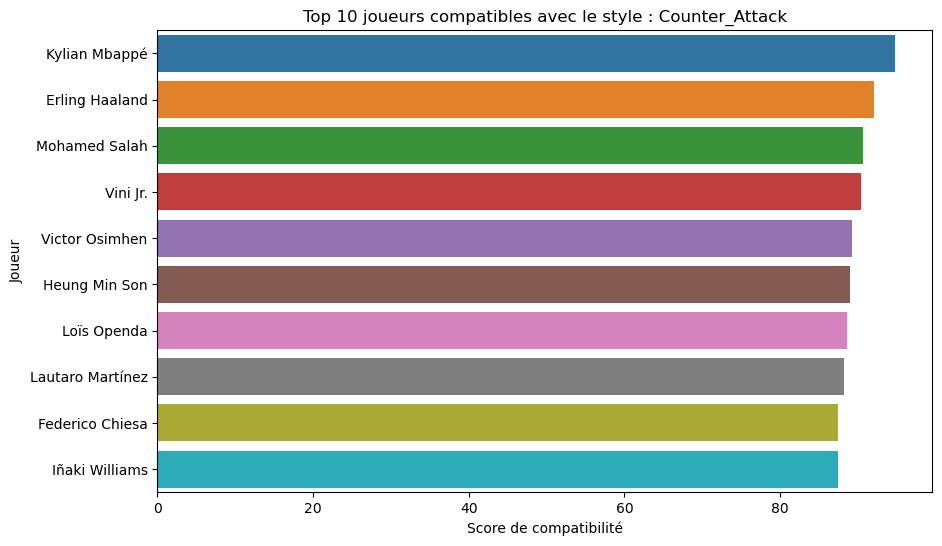

In [29]:
style = "Counter_Attack"

top_style = df_price.sort_values(f"{style}_Score", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_style,
    y="Name",
    x=f"{style}_Score",
    hue="Name",
    legend=False
)
plt.title(f"Top 10 joueurs compatibles avec le style : {style}")
plt.xlabel("Score de compatibilité")
plt.ylabel("Joueur")
plt.show()


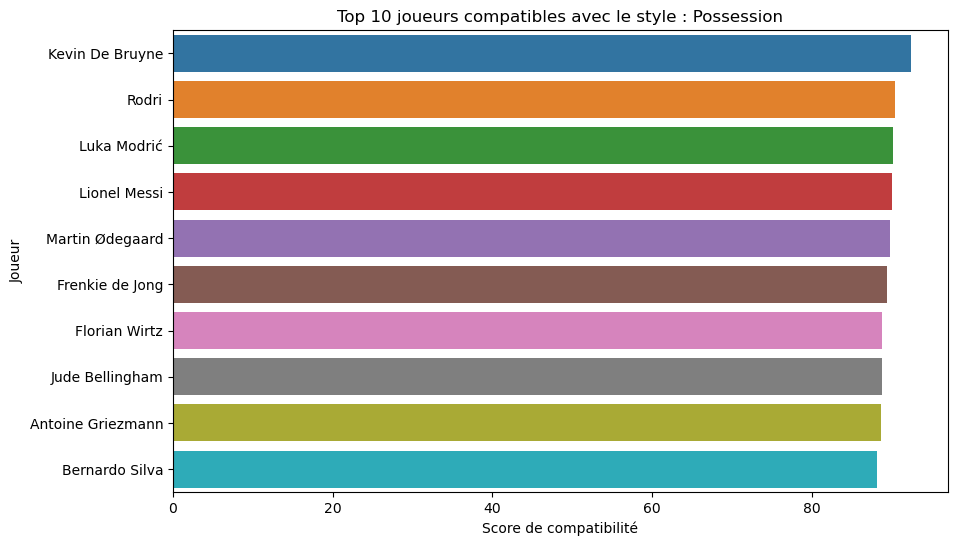

In [30]:
style = "Possession"

top_style = df_price.sort_values(f"{style}_Score", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_style,
    y="Name",
    x=f"{style}_Score",
    hue="Name",
    legend=False
)
plt.title(f"Top 10 joueurs compatibles avec le style : {style}")
plt.xlabel("Score de compatibilité")
plt.ylabel("Joueur")
plt.show()


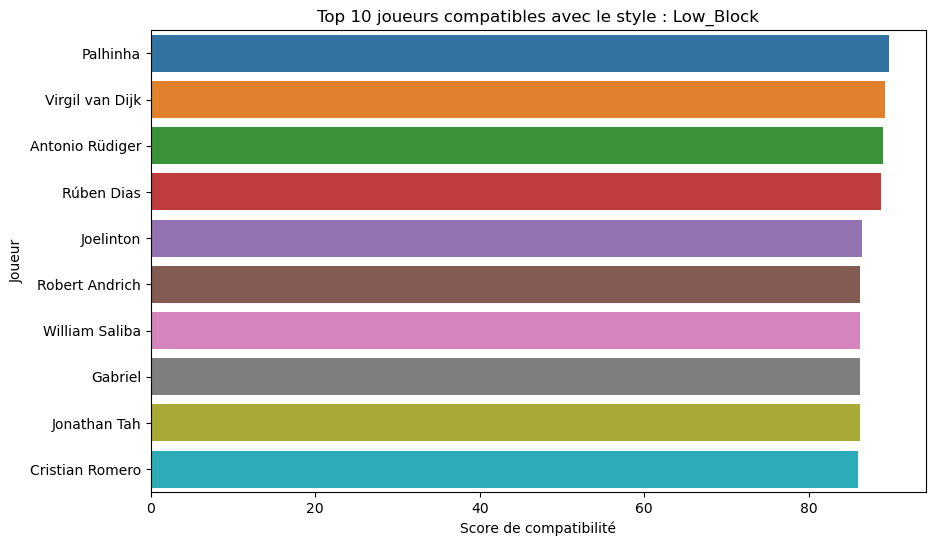

In [31]:
style = "Low_Block"

top_style = df_price.sort_values(f"{style}_Score", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_style,
    y="Name",
    x=f"{style}_Score",
    hue="Name",
    legend=False
)
plt.title(f"Top 10 joueurs compatibles avec le style : {style}")
plt.xlabel("Score de compatibilité")
plt.ylabel("Joueur")
plt.show()


## Étape 8 — Analyse qualité / prix (Value For Money)

**But :**
Identifier les joueurs offrant le meilleur rapport performance / prix estimé.

**Formule :**
VFM = Performance_Score / Estimated_Price

**Sortie :**
Top joueurs “best value” (ex : top 15) et analyse par poste/âge (optionnel).


In [32]:
df_price["VFM"] = df_price["Performance_Score"] / (df_price["Estimated_Price_M€"] )


In [ ]:
best_value = df_price[
    (df_price["OVR"] >= 0) &
    (df_price["Estimated_Price_M€"] <= 1000) &
    (df_price["Age"] <= 28)
].sort_values("VFM", ascending=False).head(20)

best_value[["Name","Age","OVR","Position","Estimated_Price_M€","Performance_Score","VFM"]]


,Name,Age,OVR,Position,Estimated_Price_M€,Performance_Score,VFM
435,Allan Saint-Maximin,27,80,LM,89.65,0.776039,0.008656
325,Riccardo Orsolini,27,81,RM,88.21,0.763461,0.008655
323,Kaoru Mitoma,27,81,LM,88.52,0.766132,0.008655
576,Galeno,26,79,LM,86.39,0.747667,0.008655
618,Edon Zhegrova,25,79,RM,84.24,0.728972,0.008654
529,Franck Honorat,28,79,RM,83.94,0.726302,0.008653
944,Antony,24,77,RM,82.63,0.714958,0.008653
1648,Adama Traoré,28,75,RM,79.69,0.689371,0.008651
1562,Joseph Paintsil,26,75,RM,78.87,0.682250,0.008650
945,Dwight McNeil,24,77,LM,78.54,0.679350,0.008650


## Étape 9 — Modèle ML : prédiction de l’OVR

**But :**
Entraîner un modèle de régression (RandomForestRegressor) pour prédire l’OVR à partir des attributs.

**Pipeline :**
1) sélection des features (attributs)
2) split train/test
3) entraînement
4) évaluation (R², MAE)
5) prédiction pour tous les joueurs → `predicted_OVR`

**Sorties attendues :**
- scores de performance du modèle
- nouvelle colonne `predicted_OVR`


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Variables explicatives = attributs numériques (hors OVR et GK)
features = candidate_attrs.copy()

X = df_enriched[features]
y = df_enriched["OVR"]

# Suppression des lignes avec NaN
mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [36]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [37]:
y_pred_test = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.2f}")


MAE : 0.87
R²  : 0.97


**Interprétation :**

Le modèle de régression obtient une **très bonne performance prédictive**, avec un coefficient de détermination **R² = 0.97**, indiquant qu’il explique 97 % de la variance de la note OVR.  
L’erreur absolue moyenne (**MAE = 0.87**) montre que les prédictions s’écartent en moyenne de moins d’un point de la note réelle, ce qui est très faible à l’échelle de l’OVR.

Ces résultats confirment que le modèle est **fiable** pour estimer le niveau global des joueurs et peut être utilisé pour des analyses comparatives ou des scénarios de scouting.


In [38]:
# Prédiction pour TOUS les joueurs valides
df_enriched.loc[mask, "predicted_OVR"] = rf.predict(X)

# Arrondir pour plus de réalisme
df_enriched["predicted_OVR"] = df_enriched["predicted_OVR"].round(1)


In [39]:
df_enriched[["Name","OVR","predicted_OVR"]].head(10)


,Name,OVR,predicted_OVR
0,Kylian Mbappé,91,90.3
1,Rodri,91,89.9
2,Erling Haaland,91,89.7
3,Jude Bellingham,90,89.2
4,Vini Jr.,90,88.6
5,Kevin De Bruyne,90,89.3
6,Harry Kane,90,89.4
7,Martin Ødegaard,89,88.6
11,Lautaro Martínez,89,88.9
12,Virgil van Dijk,89,88.0


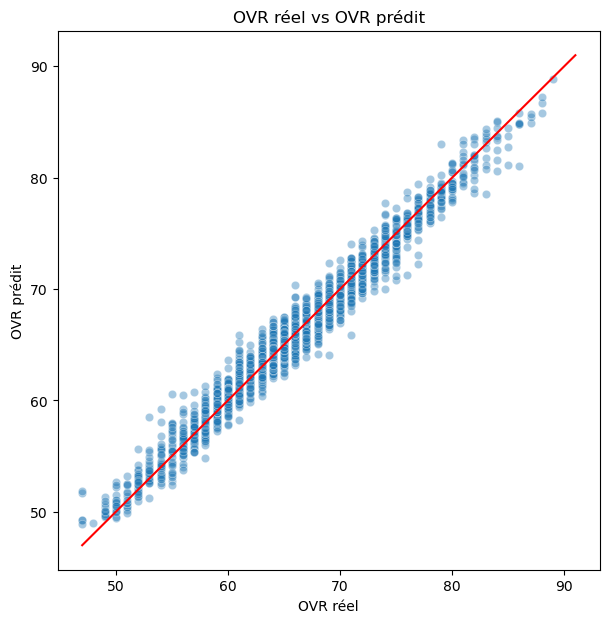

In [40]:
plt.figure(figsize=(7,7))
sns.scatterplot(
    x=y_test,
    y=y_pred_test,
    alpha=0.4
)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red")
plt.xlabel("OVR réel")
plt.ylabel("OVR prédit")
plt.title("OVR réel vs OVR prédit")
plt.show()


**Interprétation :**

Le nuage de points montre une **forte concordance** entre l’OVR réel et l’OVR prédit, avec une majorité des observations proches de la diagonale idéale.  
Cela indique que le modèle parvient à **capturer correctement la relation entre les attributs des joueurs et leur niveau global**.

Les écarts observés restent limités et ne présentent pas de biais systématique, ce qui confirme la **stabilité et la robustesse** du modèle sur l’ensemble des niveaux de performance.  
Cette cohérence visuelle est en accord avec les excellentes métriques obtenues (R² élevé et MAE faible).


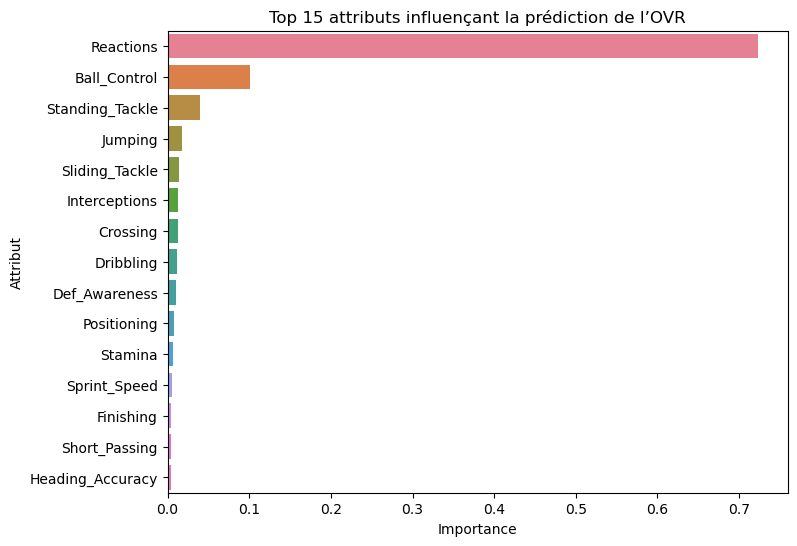

In [41]:
importances = pd.Series(
    rf.feature_importances_,
    index=features
).sort_values(ascending=False)

top15_features = importances.head(15)

plt.figure(figsize=(8,6))
sns.barplot(
    x=top15_features.values,
    y=top15_features.index,
    hue=top15_features.index,
    legend=False
)
plt.title("Top 15 attributs influençant la prédiction de l’OVR")
plt.xlabel("Importance")
plt.ylabel("Attribut")
plt.show()


**Interprétation :**

L’analyse de l’importance des variables montre que l’attribut **Reactions** domine largement la prédiction de l’OVR, confirmant son rôle central dans l’évaluation globale des joueurs.  
Les attributs techniques tels que **Ball Control** et certains critères défensifs (**tacles, interceptions**) jouent également un rôle significatif, mais de manière secondaire.

À l’inverse, les attributs purement physiques ou situationnels présentent une importance plus faible, indiquant qu’ils contribuent peu à la décision finale du modèle.

Ces résultats sont cohérents avec l’analyse de corrélation précédente et renforcent la validité du modèle, qui s’appuie principalement sur des caractéristiques **cognitives et techniques** pour estimer le niveau global des joueurs.


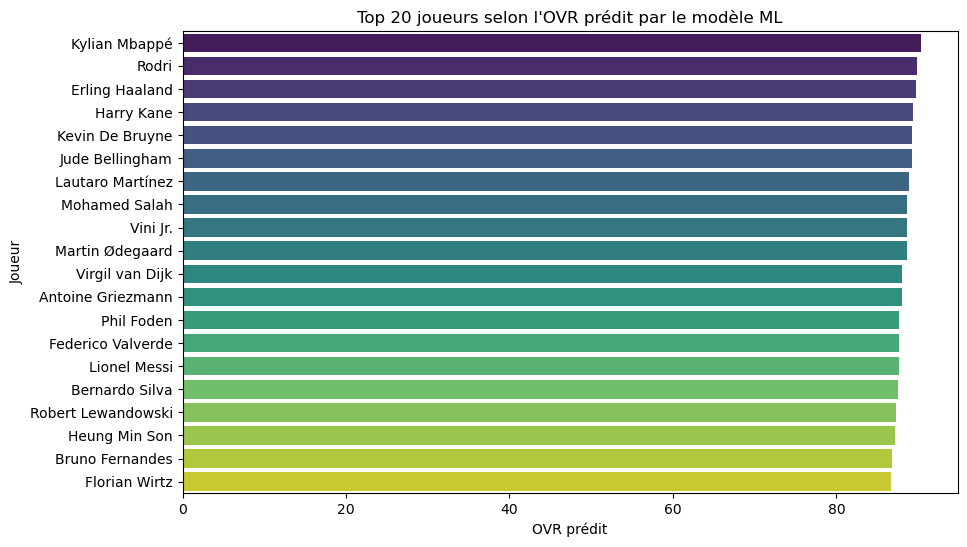

In [42]:
# Top 20 joueurs selon l'OVR prédit
top20_pred = (
    df_enriched
    .dropna(subset=["predicted_OVR"])
    .sort_values("predicted_OVR", ascending=False)
    .head(20)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top20_pred,
    y="Name",
    x="predicted_OVR",
    hue="Name",      
    legend=False,
    palette="viridis"
)

plt.title("Top 20 joueurs selon l'OVR prédit par le modèle ML")
plt.xlabel("OVR prédit")
plt.ylabel("Joueur")
plt.show()


## Conclusion – Logique de construction du projet

Ce projet a été construit selon une **démarche progressive et cohérente**, où chaque étape alimente naturellement la suivante, afin de passer d’une analyse descriptive à une véritable aide à la décision orientée **performance** et **scouting**.

- **L’analyse exploratoire initiale (EDA)** a permis de comprendre la structure du dataset FC25, la distribution de la note globale (**OVR**) et les grandes tendances liées à l’âge, au poste, aux ligues et aux nations. Cette étape constitue le socle du projet et fournit une vision globale indispensable.

- Sur la base de cette première compréhension, une **analyse des corrélations** a été réalisée afin d’identifier les attributs techniques, cognitifs et physiques influençant l’OVR. Les résultats obtenus ont mis en évidence que les déterminants de la performance varient selon le poste, ce qui a justifié une analyse plus fine et contextualisée des profils.

- Ces constats ont conduit naturellement à une phase de **feature engineering**, avec l’enrichissement de la colonne **Alternative Position**. En inférant les positions secondaires à partir des forces dominantes des joueurs et en appliquant un filtrage par familles de postes, nous avons intégré la notion de **polyvalence**, essentielle dans le scouting moderne.

- L’enrichissement des positions a ensuite permis de développer des analyses **scouting avancées**, telles que la détection de **pépites**, l’identification de joueurs sous-cotés et la construction de **shortlists par poste**, en combinant performance, âge et **polyvalence**.

- À partir de ces indicateurs sportifs, une **estimation de la valeur marchande** a été introduite afin d’ajouter une dimension économique à l’analyse. Cette estimation heuristique repose directement sur les résultats des étapes précédentes (performance, âge, poste, polyvalence), assurant une continuité méthodologique.

- L’intégration de la dimension économique a logiquement mené à une **analyse qualité / prix (Value for Money)**, visant à identifier les joueurs offrant le meilleur compromis entre performance estimée et coût de transfert, étape clé pour un recrutement optimisé sous contrainte budgétaire.

- En parallèle, les attributs analysés ont été réutilisés pour construire un **indice de compatibilité tactique**, permettant d’évaluer l’adéquation des joueurs à différents styles de jeu (contre-attaque, possession, bloc bas). Cette étape prolonge l’analyse individuelle vers une logique collective et stratégique.

- Enfin, l’ensemble des analyses a été consolidé par la mise en place d’un **modèle de machine learning** visant à prédire l’OVR à partir des attributs des joueurs. La création de la variable *predicted_OVR* permet de valider les relations observées, d’identifier des écarts entre performance réelle et estimée, et d’ouvrir des perspectives d’amélioration futures.

**En synthèse, le projet suit une logique continue et structurée :**  
*comprendre → expliquer → enrichir → décider → prédire*,  
illustrant comment une analyse de données bien construite peut évoluer vers un véritable outil d’aide à la décision appliqué au football professionnel.
